In [6]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#constantes
Kb = 8.6173324e-5

SIZE = 4
TEMPERATURAS = [i for i in np.arange(250,350.1,0.1)]
TEMPERATURA = 250
STEP = 1

E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3
N_A = 9
N_B = (SIZE * SIZE) - N_A
E_on_site = N_A * E_A + N_B * E_B

N_A_range = np.array([n for n in np.arange(0,(SIZE*SIZE)+STEP,STEP)])
N_B_range = N_A_range[::-1]
N_A_percentage = N_A_range/(SIZE*SIZE)

In [8]:
def possible_matrices(size, N_a, N_b):
    """
    size: matrix order
    N_a: number of 'A's to be placed
    N_b: number of 'B's to be placed
    """
    
    # Check if the total number of elements matches the sum of N_a and N_b
    if N_a + N_b != size * size:
        raise ValueError("The total number of 'A's and 'B's should match the size of the matrix.")
    
    # If N_a is zero, directly create a matrix filled with 'B's
    if N_a == 0:
        return np.full((1, size, size), 'B', dtype='<U1')
    
    # Generate all possible combinations of indices for 'A's
    indices_A = np.array(list(itertools.combinations(range(size*size), N_a)))
    
    # Generate matrices with 'B's filled in all cells
    matrices = np.full((len(indices_A), size, size), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (size, size))
        matrices[i][indices] = 'A'
    
    #print(len(matrices))
    return matrices


In [9]:
def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    
    vizinhos = {}
    linhas, colunas = matriz.shape

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        det_vizinhos = lambda x, y: vizinhos[(i, j)].append(matriz[x, y])
        if j < colunas - 1: det_vizinhos(i, j + 1)
        if i < linhas - 1: det_vizinhos(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: det_vizinhos(i, colunas - 1)
        if j == colunas - 1: det_vizinhos(i, 0)
        if i == 0: det_vizinhos(linhas - 1, j)
        if i == linhas - 1: det_vizinhos(0, j)

    return vizinhos


In [10]:
def energia_total(matriz, E_AB, E_AA, E_BB, E_on_site):
    """ Esta função calcula a energia de cada vizinho e a energia total da célula.
    
    Args:
        matriz: configuração da célula.
        E_AB: energias entre os elementos A e B.
        E_AA: energias entre os elementos A e A.
        E_BB: energias entre os elementos B e B.
        E_on_site: energia para o próprio sítio.
        
    Return:
        energia_célula: energia total da configuração da célula.
        energias_vizinhos: lista com os valores de energia entre cada vizinho.
    """
    vizinhos_dict = determinar_vizinhos(matriz)
    energias_vizinhos = np.array([])

    for coordenada, vizinhos in vizinhos_dict.items():
        i, j = coordenada
        elemento = matriz[i, j]
        vizinhos = np.array(vizinhos)

        # Energia entre o elemento e seus vizinhos
        energia_elemento_vizinhos = np.where(elemento != vizinhos, E_AB, 
                                              np.where(elemento == 'A', E_AA, E_BB))
        energias_vizinhos = np.concatenate((energias_vizinhos, energia_elemento_vizinhos))

    energia_célula = np.sum(energias_vizinhos) + E_on_site
    return energia_célula

In [11]:
def helmholtz(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)

    F = -(Kb * temperatura) * np.log(Z)
    
    return F

In [12]:
#tester intended for quick changes in configs
SIZE = 4
#TEMPERATURAS = [15]
TEMPERATURAS = [i for i in range(15,600,40)]

E_A = 0
E_B = 0
E_AA = -0.02
E_BB = -0.02
E_AB = -0.01

Z = 4 #vizinhos
N = 1 #N

N_A_range = np.array([n for n in np.arange(0,(SIZE*SIZE)+STEP,STEP)])
N_B_range = N_A_range[::-1]
N_A_percentage = N_A_range/(SIZE*SIZE)

In [13]:
def analise(size, N_a_range, N_b_range, temperaturas):
    energia_matrix_list = []
    energia_helmholtz_list = []
    temperaturas_list = []
    concentracao_list = []
    x_axis = []

    for T in temperaturas:
        for N_a, N_b in zip(N_a_range,N_b_range):
            #print('concen',N_a,N_b)
            energia_matrix_list = []
            matrices = possible_matrices(size,N_a,N_b)

            for matrix in matrices:
                energia_matrix = energia_total(matrix, E_AB, E_AA, E_BB, E_on_site)
                energia_matrix_list.append(energia_matrix)
        
            energia_helmholtz = helmholtz(energia_matrix_list,T)
            energia_helmholtz_list.append(energia_helmholtz)
            concentracao_list.append([N_a,N_b])
        
        temperaturas_list.extend([T]*((size*size) + 1))
        x_axis.extend(N_a_range)

    data = pd.DataFrame({"[N_a, N_b]": concentracao_list, "Energia de Helmholtz [eV]": energia_helmholtz_list, "Temperatura [K]": temperaturas_list, "x_axis": x_axis})
    return data

In [14]:
helmholtz_energies = analise(SIZE,N_A_range,N_B_range,TEMPERATURAS)
helmholtz_energies

KeyboardInterrupt: 

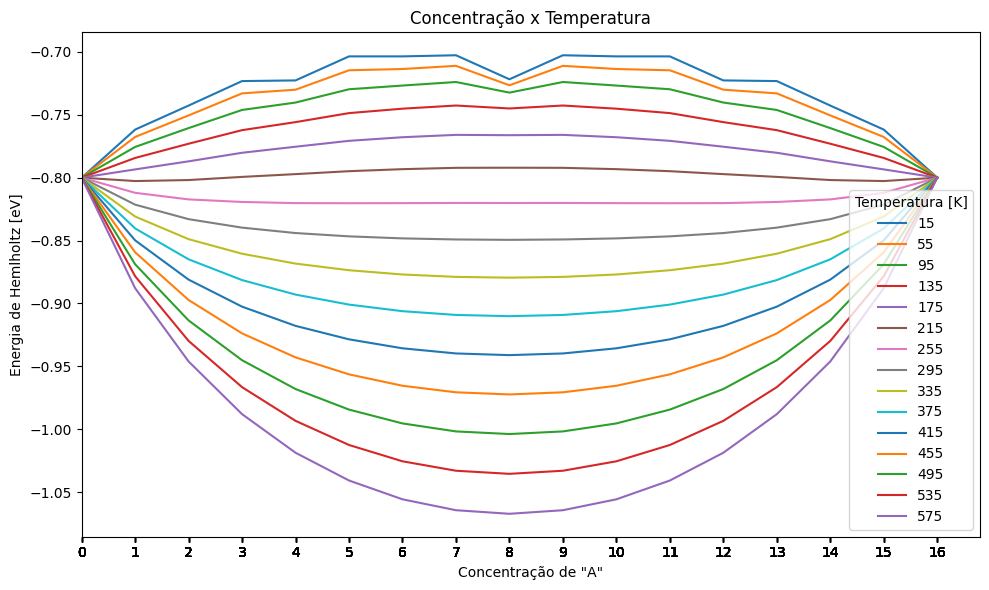

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#sns.scatterplot(x=N_A_percentage, y=helmholtz_energies,c='red')
sns.lineplot(x=helmholtz_energies["x_axis"], y=helmholtz_energies["Energia de Helmholtz [eV]"],hue=helmholtz_energies["Temperatura [K]"],palette='tab10')
plt.xlim(0, None)
#plt.ylim(0, None)
plt.xticks(helmholtz_energies["x_axis"])
plt.title('Concentração x Temperatura')
plt.xlabel('Concentração de "A"')
plt.ylabel('Energia de Hemlholtz [eV]')
plt.tight_layout()
fig.get_figure() #'pega' o gráfico para salvar
fig.savefig("helmholtz.png") #salva o gráfico 

In [15]:
Kb = 8.6173324e-5
#tester intended for quick changes in configs
SIZE = 4
TEMPERATURAS = [20,30]
#TEMPERATURAS = [i for i in range(15,600,40)]

E_A = 0
E_B = 0
E_AA = -0.02
E_BB = -0.02
E_AB = -0.01

Z = 4 #vizinhos
N = 1 #N

N_A_range = np.array([n for n in np.arange(0,(SIZE*SIZE)+STEP,STEP)])
N_B_range = N_A_range[::-1]
N_A_percentage = N_A_range/(SIZE*SIZE)

In [16]:
interactionEnergies['Epp'] = E_AA
interactionEnergies['Ess'] = E_BB
interactionEnergies['Eps'] = E_AB

NameError: name 'interactionEnergies' is not defined

In [17]:
def pappu(T, sigma):
    global Kb, interactionEnergies
    if (sigma == 0) or (sigma == 1):
        return 0
    xi = 4/(Kb*T) * (E_AB - (E_AA + E_BB)/2)
    first = sigma*np.log(sigma)
    second = (1-sigma)*np.log(1-sigma)
    third = xi*sigma*(1-sigma)

    return Kb*T * (first + second + third)

In [18]:
def campo_medio_hemlholtz(size, N_a_range,N_b_range,z,temperaturas,E_AA,E_BB,E_AB):
    energia_campo_medio  = []
    F_values = []
    x_axis = []
    temperaturas_list = []

    chi = lambda E_AA,E_BB,E_AB,T,z : (z/(Kb * T)) * (E_AB - ((1/2)*(E_AA + E_BB)))

    for T in temperaturas:
        X = chi(E_AA,E_BB,E_AB,T,z)
        #print(X)
        F = 0.0
        for N_a, N_b in zip(N_a_range,N_b_range):
            W = N_a/(size*size)
            #print(W)
            F = (W/N)*(np.log(W) + ((1 - W) * np.log(1 - W)) + (X * W * (1 - W))) * Kb * T
            #print(N_a,N_b)
            #print(F)
            F_values = np.append(F_values,F)
            print(F_values)
            F_values = np.nan_to_num(F_values, nan=0)
            energia_campo_medio.append(sum(F_values))
        x_axis.extend(N_a_range)
        temperaturas_list.extend([T]*((size*size) + 1))

    print(len(energia_campo_medio), len(x_axis))
    data = pd.DataFrame({"Energia de Helmholtz [eV]": energia_campo_medio, "x_axis": x_axis, "Temperatura [K]": temperaturas_list})

    return data

In [19]:
campo_medio = campo_medio_hemlholtz(SIZE,N_A_range,N_B_range,Z,TEMPERATURAS,E_AA,E_BB,E_AB)
campo_medio

[0.]
[0.         0.00194082]
[0.         0.00194082 0.00372565]
[0.         0.00194082 0.00372565 0.00526204]
[0.         0.00194082 0.00372565 0.00526204 0.00653083]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263 0.00880538]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263 0.00880538 0.00866263]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263 0.00880538 0.00866263 0.00823482]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263 0.00880538 0.00866263 0.00823482 0.00752333]
[0.         0.00194082 0.00372565 0.00526204 0.00653083 0.00752333
 0.00823482 0.00866263 0.00880538 0.00866263 0.008234

,Energia de Helmholtz [eV],x_axis,Temperatura [K]
0,0.000000,0,20
1,0.001941,1,20
2,0.005666,2,20
3,0.010929,3,20
4,0.017459,4,20
5,0.024983,5,20
6,0.033217,6,20
7,0.041880,7,20
8,0.050686,8,20
9,0.059348,9,20


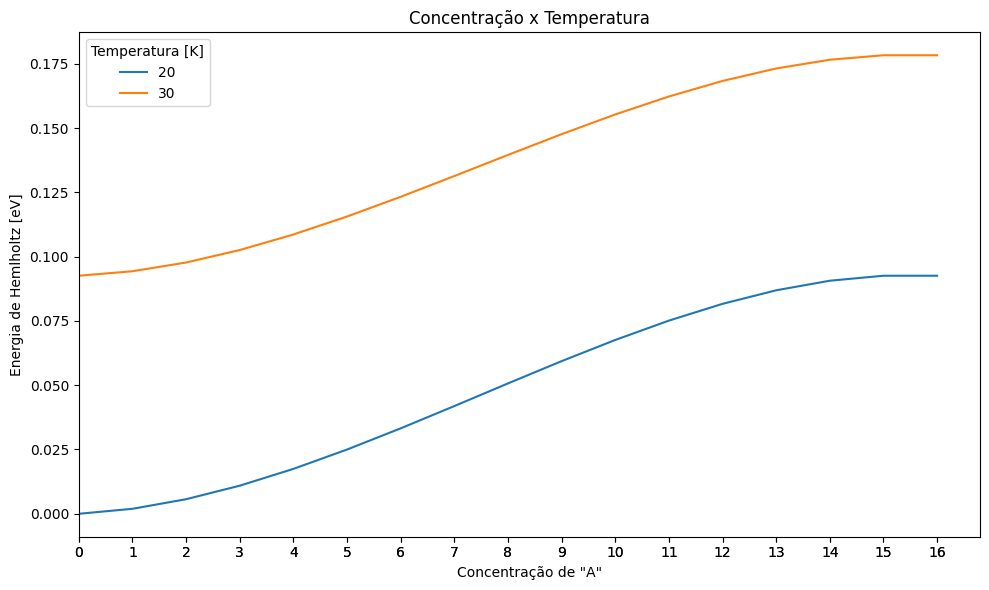

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
#sns.scatterplot(x=N_A_percentage, y=helmholtz_energies,c='red')
sns.lineplot(x=campo_medio["x_axis"], y=campo_medio["Energia de Helmholtz [eV]"],hue=campo_medio["Temperatura [K]"],palette='tab10')
plt.xlim(0, None)
#plt.ylim(0, None)
plt.xticks(campo_medio["x_axis"])
plt.title('Concentração x Temperatura')
plt.xlabel('Concentração de "A"')
plt.ylabel('Energia de Hemlholtz [eV]')
plt.tight_layout()
fig.get_figure() #'pega' o gráfico para salvar
fig.savefig("helmholtz.png") #salva o gráfico 

In [1]:
def pappu(T, sigma):
    global Kb, interactionEnergies
    if (sigma == 0) or (sigma == 1):
        return 0
    xi = 4/(Kb*T) * (interactionEnergies['Eps'] - (interactionEnergies['Epp'] + interactionEnergies['Ess'])/2)
    first = sigma*np.log(sigma)
    second = (1-sigma)*np.log(1-sigma)
    third = xi*sigma*(1-sigma)

    return Kb*T * (first + second + third)

### Playground

In [ ]:
import matplotlib.colors as mcolors

# Example list of temperatures
temperatures = [20, 25, 30, 35, 40]

# Generate colors based on a colormap
colormap = plt.cm.viridis  # You can choose any colormap you prefer
norm = mcolors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
colors_rgb = [colormap(norm(temp)) for temp in temperatures]

# Convert RGB colors to hexadecimal strings
colors_hex = [mcolors.rgb2hex(color) for color in colors_rgb]

print(colors_hex)


['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']


In [ ]:
import numpy as np

# Define the lambda function to invert the matrix
invert_matrix = lambda matrix: np.array([['A' if x == 'B' else 'B' for x in row] for row in matrix])

# Example usage:
original_matrix = np.array([['A', 'A', 'B'],
                            ['B', 'A', 'B'],
                            ['A', 'B', 'B']])

inverted_matrix = invert_matrix(original_matrix)
print("Original Matrix:")
print(original_matrix)
print("\nInverted Matrix:")
print(inverted_matrix)


Original Matrix:
[['A' 'A' 'B']
 ['B' 'A' 'B']
 ['A' 'B' 'B']]

Inverted Matrix:
[['B' 'B' 'A']
 ['A' 'B' 'A']
 ['B' 'A' 'A']]


In [ ]:
import numpy as np

def invert_matrix(matrix):
    # Define mapping dictionary for inversion
    inversion_map = {'A': 'B', 'B': 'A'}
    
    # Convert the matrix to a NumPy array if it's not already
    matrix = np.array(matrix)
    
    # Apply the inversion mapping using vectorized operations
    inverted_matrix = np.vectorize(inversion_map.get)(matrix)
    
    return inverted_matrix

# Example usage:
original_matrix = np.array([['A', 'A', 'B'],
                            ['B', 'A', 'B'],
                            ['A', 'B', 'B']])

inverted_matrix = invert_matrix(original_matrix)
print("Original Matrix:")
print(original_matrix)
print("\nInverted Matrix:")
print(inverted_matrix)


Original Matrix:
[['A' 'A' 'B']
 ['B' 'A' 'B']
 ['A' 'B' 'B']]

Inverted Matrix:
[['B' 'B' 'A']
 ['A' 'B' 'A']
 ['B' 'A' 'A']]


In [ ]:
a = (possible_matrices(3,3,6))
print("a")
b = (possible_matrices(3,6,3))

a


In [ ]:
c = determinar_vizinhos(a[0])
d = determinar_vizinhos(b[0])

print(c)
print("a")
print(d)

{(0, 0): ['A', 'B', 'A', 'B'], (0, 1): ['A', 'B', 'B'], (0, 2): ['B', 'A', 'B'], (1, 0): ['B', 'B', 'B'], (1, 1): ['B', 'B'], (1, 2): ['B', 'B'], (2, 0): ['B', 'B', 'A'], (2, 1): ['B', 'A'], (2, 2): ['B', 'A']}
a
{(0, 0): ['A', 'A', 'A', 'B'], (0, 1): ['A', 'A', 'B'], (0, 2): ['A', 'A', 'B'], (1, 0): ['A', 'B', 'A'], (1, 1): ['A', 'B'], (1, 2): ['B', 'A'], (2, 0): ['B', 'B', 'A'], (2, 1): ['B', 'A'], (2, 2): ['B', 'A']}


In [ ]:
E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3

In [ ]:
temperaturas = [250]
n=3
E_on_site = N_A * E_A + N_B * E_B

In [ ]:
def Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas):
    """Essa função realiza toda a análise de caso
    
    Args:
        N_A: número de átomos A.
        N_B: número de átomos B.
        n: ordem da célula quadrada.
        E_AB: energia entre A e B.
        E_AA: energia entre A e A.
        E_BB: energia entre B e B.
        temperatura: intervalo de temperatura em que analisaremos a célula.
        
    Return:
    
        data: dataframe com as informações de temperatura e energia livre de helmholtz.
    """
    energias = []
    lista_helm = []
    células = possible_matrices(n,N_A, N_B)
    
    for cell in células:
        energia_célula = energia_total(cell, E_AB, E_AA, E_BB,E_on_site)
        energias.append(energia_célula)
    
    for T in temperaturas:
        F = helmholtz(energias, T)
        lista_helm.append(F)
    
    data = pd.DataFrame({"Temperatura": temperaturas, "F": lista_helm})
    return data

In [ ]:
size = SIZE
step = STEP
print(STEP)

N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
print(N_A_range)
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)


1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0.          0.06666667  0.14285714  0.23076923  0.33333333  0.45454545
  0.6         0.77777778  1.          1.28571429  1.66666667  2.2
  3.          4.33333333  7.         15.          1.        ]


/tmp/ipykernel_2549/2932245074.py:8: RuntimeWarning: divide by zero encountered in divide
  N_A_B_ratio = N_A_range / N_B_range


In [ ]:
lst = [-10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2]
helmholtz(lst, 270.1)

18947.169590983623

In [ ]:
def calcular_vizinhos_v1(matriz):
    linhas, colunas = matriz.shape
    vizinhos = {}

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    indices = itertools.product(range(linhas), range(colunas))

    for i, j in indices:
        vizinhos[(i, j)] = []

        # Calculate indices of neighboring elements
        neighbor_indices = (np.array([i, j]) + offsets) % np.array([linhas, colunas])

        # Add neighbors to the current element
        for ni, nj in neighbor_indices:
            vizinhos[(i, j)].append(matriz[ni, nj])

    return vizinhos

# Example usage
matriz = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
vizinhos = calcular_vizinhos_v1(matriz)
print(vizinhos)


{(0, 0): [2, 4, 3, 7], (0, 1): [3, 5, 1, 8], (0, 2): [1, 6, 2, 9], (1, 0): [5, 7, 6, 1], (1, 1): [6, 8, 4, 2], (1, 2): [4, 9, 5, 3], (2, 0): [8, 1, 9, 4], (2, 1): [9, 2, 7, 5], (2, 2): [7, 3, 8, 6]}


In [ ]:
import numpy as np

def determinar_vizinhos_v2(matrix, size):
    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size, size])

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): [matrix[neighbor_indices[x, y, k, 0]][neighbor_indices[x, y, k, 1]] for k in range(neighbor_indices.shape[2])] for x in range(size) for y in range(size)}

    return vizinhos

matriz_teste = [['AA', 'AB', 'BB'], ['AB', 'BB', 'BB'], ['BB', 'BB', 'BB']]
determiar_vizinho = determinar_vizinhos_v2(matriz_teste, 3)
print(determiar_vizinho)


{(0, 0): ['AB', 'AB', 'BB', 'BB'], (0, 1): ['AB', 'AB', 'BB', 'BB'], (0, 2): ['AB', 'AB', 'BB', 'BB'], (1, 0): ['BB', 'BB', 'AB', 'AB'], (1, 1): ['BB', 'BB', 'AB', 'AB'], (1, 2): ['BB', 'BB', 'AB', 'AB'], (2, 0): ['BB', 'BB', 'BB', 'BB'], (2, 1): ['BB', 'BB', 'BB', 'BB'], (2, 2): ['BB', 'BB', 'BB', 'BB']}


In [ ]:
import numpy as np
import itertools

def possible_matrices(N_A, N_B, n):
    total = N_A + N_B
    
    # Generate all possible combinations of indices for 'A's
    all_indices_A = list(itertools.combinations(range(n*n), N_A))
    
    # Generate matrices with 'B's filled in all cells
    matrices_B = np.full((len(all_indices_A), n, n), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(all_indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (n, n))
        matrices_B[i][indices] = 'A'
    
    print(len(matrices_B))
    return matrices_B

# Example usage:
N_A = 3
N_B = 6
n = 3
result = possible_matrices(N_A, N_B, n)

# Printing the matrices
for matrix in result:
    print(matrix)
    print()


84
[['A' 'A' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'A']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['A' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['B' 'A' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 

In [ ]:
import itertools

def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    vizinhos = {}
    linhas, colunas = len(matriz), len(matriz[0])

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        append_neighbor = lambda x, y: vizinhos[(i, j)].append(matriz[x][y])
        if j < colunas - 1: append_neighbor(i, j + 1)
        if i < linhas - 1: append_neighbor(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: append_neighbor(i, colunas - 1)
        if j == colunas - 1: append_neighbor(i, 0)
        if i == 0: append_neighbor(linhas - 1, j)
        if i == linhas - 1: append_neighbor(0, j)

    return vizinhos
